# Final project - Duy Pham - Minerva Schools at KGI- CS146 - Prof. Scheffler

## ACCESS TO THE CODE ON GOOGLE COLAB

Link to the code on Google Colab: https://colab.research.google.com/drive/13qHwY-9wypZEeiMFanWBZevLpLldeXI-#scrollTo=0Ipb1-S3_P7t. Or the short link: https://bit.ly/2QKckb2

As the code structure on Google Colab is different from the Jupyter Python, please access the Google Colab to run the code. 

## PREPARATION

In [0]:
import pystan 
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import date
import seaborn
import math
import time
%matplotlib inline

In [43]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving weekly_in_situ_co2_mlo.csv to weekly_in_situ_co2_mlo (1).csv
User uploaded file "weekly_in_situ_co2_mlo.csv" with length 55121 bytes


In [0]:
data = pd.read_csv("weekly_in_situ_co2_mlo.csv")

In [49]:
#Calculate the date difference between the date_time and the first recorded day 
data["Time"] = pd.to_datetime(data["Time"])
Date_diff = pd.Series(delta.days for delta in (data["Time"] - data["Time"][0]))

#Normalize the CO2 value
CO2_norm = pd.Series(i for i in (data["CO2"] - 
                                 min(data["CO2"]))/(max(data["CO2"]-min(data["CO2"]))))

data['Date_diff'] = Date_diff
data['CO2_norm'] = CO2_norm
data

,Time,CO2,Date_diff,CO2_norm
0,1958-03-29,316.19,0,0.031892
1,1958-04-05,317.31,7,0.043232
2,1958-04-12,317.69,14,0.047079
3,1958-04-19,317.58,21,0.045965
4,1958-04-26,316.48,28,0.034828
5,1958-05-03,316.95,35,0.039587
6,1958-05-17,317.56,49,0.045763
7,1958-05-24,317.99,56,0.050116
8,1958-07-05,315.85,98,0.028450
9,1958-07-12,315.85,105,0.028450


4.3228025542617467e-05 -0.06757319136545459


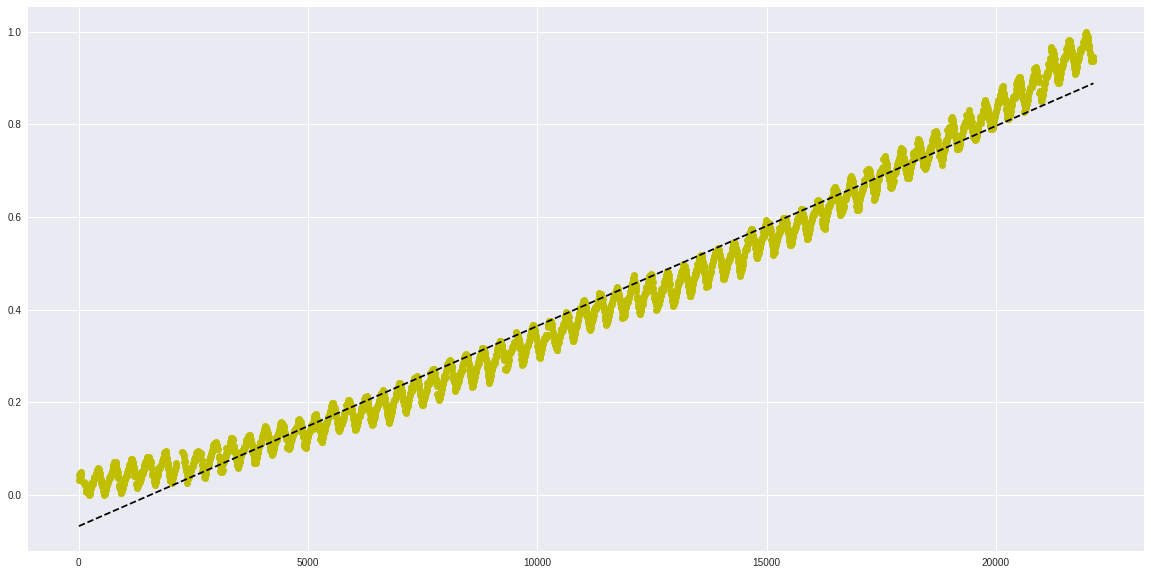

In [50]:
m,b = np.polyfit(Date_diff,CO2_norm,1)
fit = np.polyfit(Date_diff,CO2_norm,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.figure(figsize=(20,10))
plt.plot(Date_diff,CO2_norm, 'yo',Date_diff , fit_fn(Date_diff), '--k')
print (m,b)

The fitted regression line gives a hint about the constant terms for the model. These constants will be used as prior to inform the Pystan model about the parameters below.

## **OVERVIEW OF THE ORIGINAL MODEL**

---



The **scenario** you are modeling, what **assumptions** you made and why, what your **parameters** are, what the priors over your parameters are and how you selected your **priors**.

* **Scenario**: We have the recorded data of CO2 from 1958 to 2018. The data has two variables: the day of the recording and the variable to measure: CO2 (ppm - parts per million). We want to forecast how the CO2 would look like from 2018 to 2058. Also, we would like to know when we will reach the high-level of CO2 that is dangerous for the climate change. The threshold for the CO2 level is 450 ppm. 

* **Assumptions**: This model has one main assumption: the data comes from a normal distribution with the mean of the distribution is the sum of the long-term trend and seasonal variation. The long-term trend is assumed to be a linear model under the form $c_0 + c_1t$ while the seasonal variation is assumed to have the cosin function, expressed by the form $c_2cos(2t\pi/365.25+c_3)$. 
* **Parameters and priors**:

 * **c0**: Intercept of the long_term trend): With the long term trend. I drew a regression line and estimated the value of the intercept of that regression line. The calculated variable is considered to be the mean of the normal distribution in the Stan model

 * **c1** (slope of the long_term trend): With the long term trend. I drew a regression line and estimated the value of the slope of that regression line. The calculated variable is considered to be the mean of the normal distribution in the Stan model. Plotting the regression line, we can see the graph going upward as we move x-value to the right. This means that the slope of the long_term must be positive. 

 * **c2**(amplitude of the seasonal variation): I chose Cauchy (0,0.1) as this normal distribution has a reasonable tail.

 * **c3** (phi of the cosin function of the seasonal variation): I chose Cauchy (0,0.1) as this normal distribution has a reasonable tail. I put the constraint of $c_3$ from $-\pi$  to $\pi$ value because the the region from $-\pi$  to $\pi$  has covered all the possible values of cosin. 

 * **c4** (noise of the model): I chose Cauchy (0,0.1) as this normal distribution has a reasonable tail.


Clearly describe the **observed** and **unobserved** quantities of your model.

*   The observed quantities of my model is the date of recording (t) and the CO2 recorded data (y) from 1958 to 2018. There are a total of 3040 data values for both quantities. The unobserved quantitties of the model is the data values from 2018 to 2058. I will predict every single day from  2018 to 2058, which means that I would have more than 14000 unobserved data values

*If you did any mathematical derivations to **simplify** or **approximate** your model analytically, include those in an appendix*

* In order to easily calculate the y-value, I normalize the CO2 value from 1958 to 2018. In the graph below, from 2018 to 2058, the data value ranges from 0 to 1. However, from 2018, y-values are usually higher than 1. This is because maximum value for y-axis is the CO2 amount in 2018. Values higher than 1 implies that CO2 amount increases after 2018. 

*Describe how you did inference in your model, any complications that arose, and how you resolved them 

* I used Stan model to replicated the result. The original model has the assumptions stated in the model; thus, I have no difficulty in running the model. 



## Original model

In [0]:
Date = Date_diff.tolist() #Date difference
CO2 = CO2_norm.tolist() #CO2 amount
N = len(CO2) #Number of days

#Calculate the number of future date to predict
from datetime import date
f_date = date(2018, 10, 27)
l_date = date(2058, 1,1)
Date_future = (l_date - f_date).days

In [25]:
st = time.time()

stan_data = {
  'CO2': CO2,
  'Date': Date,
  'N': N,
  'Date_future': Date_future}

stan_code = """
data {
  int<lower=0> N;  // Number of data
  real CO2[N];       // CO2 amount value
  int <lower=0> Date[N]; // Date value
  int<lower=0> Date_future; // Future data to predict
}

parameters {
  real c0;     // Intercept of the linear long-term trend
  // Looking from the linear plot above, as the plot is going upward, the Slope is strictly positive
  real <lower=0> c1; 
  // Seasonal variation
  real <lower=0> amplitude ;       
  // A variable of the function cosin
  real <lower=-pi(),upper=pi()> phi; 
  // Noise
  real sigma;                      
}

model {
  // Priors over 5 parameters
  c0 ~ normal(-0.0677,0.1); // The mean of c0 is extracted from the polynomial model
  c1 ~ normal(0.000043,0.1); // The mean of c1 is extracted from the polynomial model
  phi ~ cauchy (0,0.1); //The seasonal variation is smaller than long-term trend
  amplitude ~ cauchy (0, 0.1); //The seasonal variation is smaller than long-term trend
  sigma ~ cauchy (0,0.1); //Noise variation is smaller than long-term trend
  
  // Likelihood
  for(i in 1:N) {
    CO2[i] ~ normal(c0 + c1*Date[i] + amplitude*cos((2*pi()*Date[i])/(365.25+phi)), sigma);
  }
}

// Generate the predicted function values for the next date_future days.
generated quantities {
    real x_future[Date_future];
    for(t in 1:Date_future) {
        x_future[t] = normal_rng(
            c0 + c1*(Date[N]+t) + amplitude*cos((2*pi()*(Date[N]+t))/(365.25+phi)), sigma);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)
print ("Elapsed time %f" %(time.time() - st))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37b073de81c4036f7b04dd7c4f62db6c NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpranabxje/stanfit4anon_model_37b073de81c4036f7b04dd7c4f62db6c_4598378362911365284.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Elapsed time 77.554507


In [26]:
st = time.time()
parameters = ['c0', 'c1', 'amplitude', 'phi','sigma']
results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()
print ("Elapsed time %f" %(time.time() - st))

Inference for Stan model: anon_model_37b073de81c4036f7b04dd7c4f62db6c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0         -0.07  2.4e-5 1.4e-3  -0.07  -0.07  -0.07  -0.07  -0.06   3109    1.0
c1        4.3e-5  1.9e-9 1.0e-7 4.3e-5 4.3e-5 4.3e-5 4.3e-5 4.3e-5   3041    1.0
amplitude   0.03  2.1e-5 9.4e-4   0.03   0.03   0.03   0.03   0.03   2093    1.0
phi         0.59  1.1e-3   0.05   0.49   0.56   0.59   0.63   0.69   2035    1.0
sigma       0.04  7.0e-6 4.6e-4   0.04   0.04   0.04   0.04   0.04   4314    1.0

Samples were drawn using NUTS at Fri Dec 21 15:56:58 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Elapsed time 542.961097


**The result above shows that the MCMC sampling in Stan model returns a good result.** 

---

1.   Firstly, the n_eff represents an estimate of how many of these 4000 samples are uncorrelated. The rule of thumb for an effective sample size is 10% of the total number of samples. In this case, the n_eff is reasonably good if it is above 400. Obviously, the model converges with more than 2000 uncorrelated samples. This model works well. 
2.   Secondly, the Rhat will give us a hint whether the MCMC chain has converged. The MCMC model will compute 4 different Markov chain by default. Rhat is computed by dividing the average variance of 1 chain by the variance of all samples from all chain. If Markov chain converges, Rhat should equal to 1. The value of 1 implies that there is every likelihood that all the Markov chains have covered all the properties of the distribution well without missing any particular mode. Of course, there is still a chance that all 4 chains started at one mode and could not move to the another modes. In that case, Rhat can still be 1 but the parameter extracted from Stan would fail to generate similar samples. In the Stan model above, as Rhat equals to 1.0, we can relatively conclude that the MCMC model covers all the modes of the real distribution of data. 




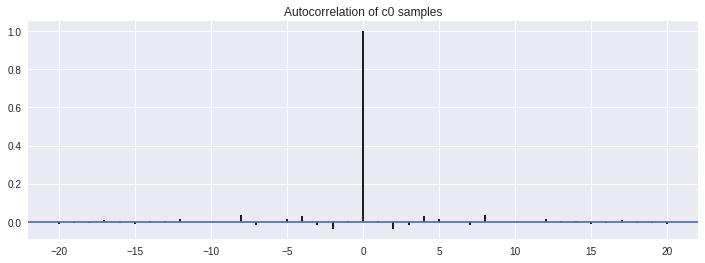

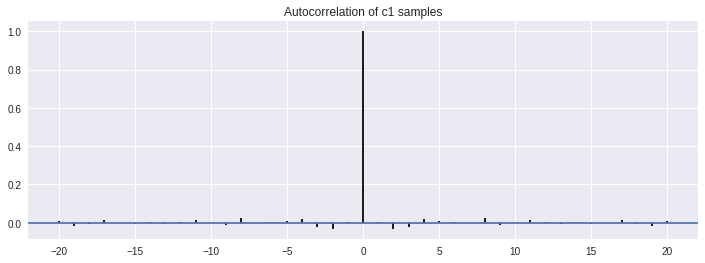

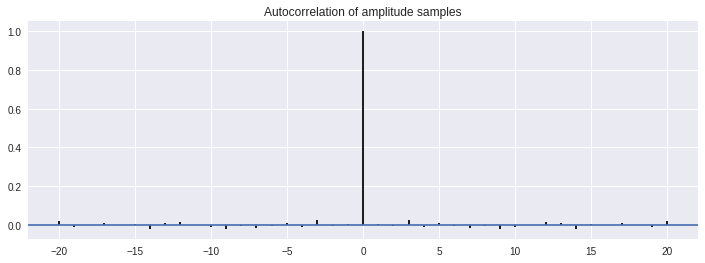

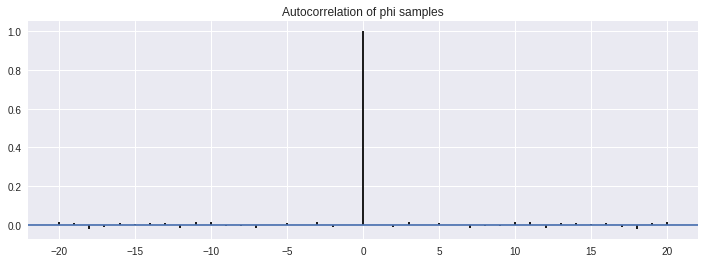

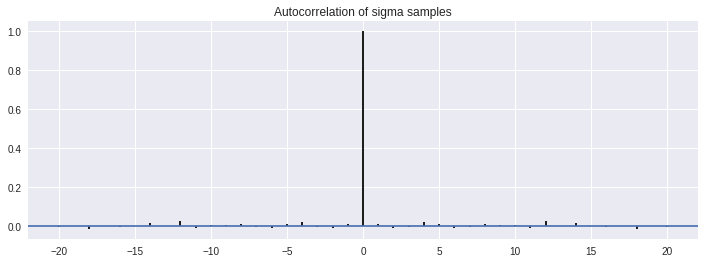

In [27]:
#Plot the autocorrelation function for a series x. 
def plot_acf(x):
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

**Intepreting auto correlation of parameters**

---

The autocorrelation graphs imply a good independence of all those parameters. The rule of thumb for the value of the correlation is below 0.05. In this case, it seems that in all lags (especially lag 1), the autocorrelation stays below 0.05. This means that the samples of those parameters are uncorrelated. 


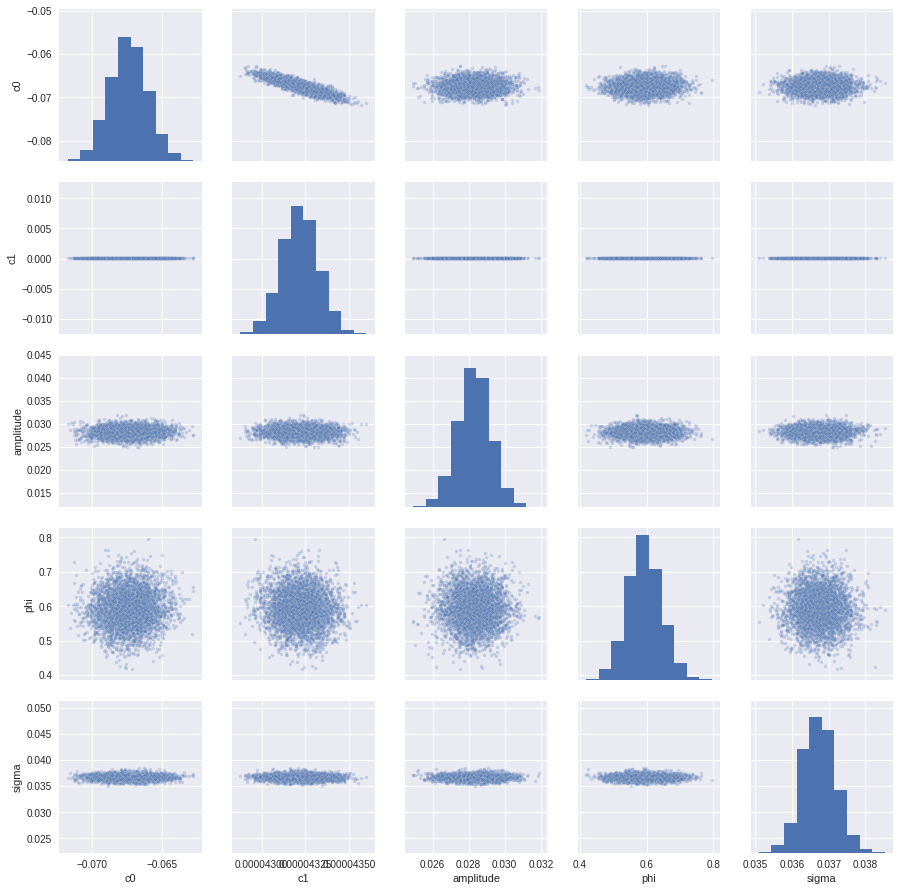

In [28]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

#The pair plots are useful for diagnosing the high-dimensional distribution. In this case, we can 
#plot the relationship between every two parameters in one plot; even though we cannot plot the 
#5-dimensional distribution.

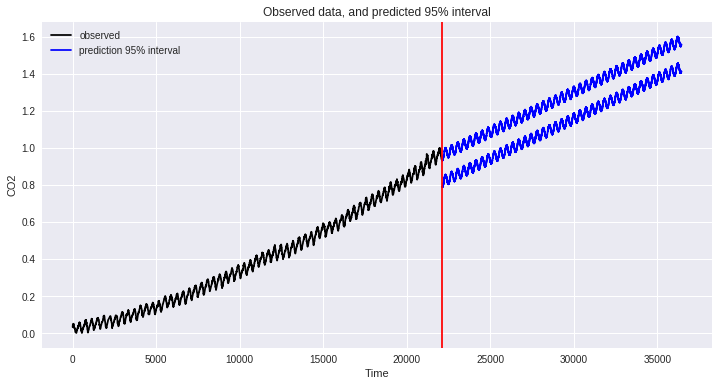

In [29]:
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
x_plot = [max(Date_diff) + i + 1 for i in range (Date_future)]
plt.plot(Date_diff,CO2_norm, 'k-', label='observed')
plt.plot(x_plot,prediction_interval[0],'b-', label='prediction 95% interval') #Lower bound
plt.plot(x_plot, prediction_interval[1],'b-') #Upper bound
plt.axvline(max (Date_diff), color='red')
plt.xlabel('Time')
plt.ylabel('CO2')
plt.legend()
plt.title('Observed data, and predicted 95% interval')
plt.show()

**Intepretation from the graph above**

---

1.   The y-axis resembles the normalized CO2 amount from 1958 to 2018. The data is normalized using data from 1958 to 2018. In addition, the x-axis resembles the number of days from the start of the recorded day in 1958 to the beginning of 2058. In this model, the red vertical line separates the observed variables (recorded data) on the left with the unobserved data on the right. As can be seen from the graph, we don't see any black plot in the right graph because we have not observed those variables.
2.   The blue plot resembles the 95% confidence calculated by the Stan model. The upper line resembles the upper bound, while the lower line resembles the lower bound. However, looking at the graph, it seems that the prediction does not predict accurately enough. The unobserved value has an intention of moving above the upper bound of the confidence interval. We will do some test statistics to check the result. 



**Test statistic**

---

Looking at the graph, we can see that the confidence interval does not seem to capture the future value well. The black figure (observed variable from 1958 to 2018) nearly goes above the upper bound of the confidence interval. This raises the question about the validity of the prediction; hence, I will use two test statistics to see the validity of this model. The first test statistic calculates the proportion of data that lies within the boundary from $(\mu-\sigma)$ to $(\mu+\sigma)$. 

In [0]:
def test_statistic(data): #The test statistic is the calculation of the proportion 
                          #of data that lies within the boundary from (mu-std) to (mu+std)
    mu = np.mean(data)  
    sigma = np.std(data, ddof=1)  
    return np.mean((data > mu - sigma) & (data < mu + sigma))

In [0]:
def test_statistic_2 (data):
  mean = np.mean(data)
  return mean

In [0]:
true_value = test_statistic (CO2) #Calculate the first test statistic of the true samples
true_value_2 = test_statistic_2 (CO2) #Calculate the second test statistic of the true samples

In [33]:
#Using the first test statistic (calculate the proportion of data that lies within the boundary from (mu-std) to (mu+std))
st = time.time()


replicated_test_statistic = []
for i in range (100):
  replicated_data =[]
  test=[]
  for t in Date_diff:
    replicated = stats.norm(samples['c0'][i] + samples['c1'][i]+ samples['amplitude'][i]*
                            math.cos((2*math.pi*t)/(365.25+ samples['phi'][i])), samples['sigma'][i]).rvs (size=1)
    replicated_data.append(replicated)
  test = test_statistic (replicated_data)
  replicated_test_statistic.append(test)
print ("Elapsed time %f" %(time.time() - st))

Elapsed time 253.370822


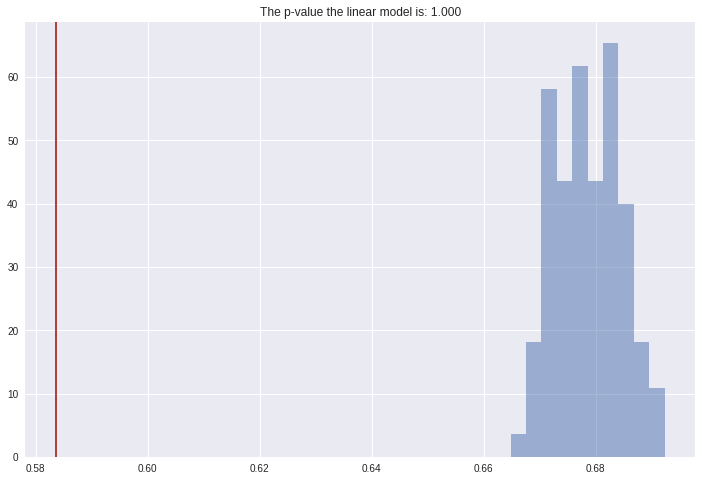

In [34]:
ps= [replicated_test_statistic[_] > true_value for _ in range(len(replicated_test_statistic))]
plt.figure(figsize=(12,8))
plt.hist(replicated_test_statistic, alpha = 0.5, density = True)
plt.axvline(x=true_value, color = 'brown')
plt.title ('The p-value the linear model is: %.3f' %np.mean(ps))
plt.show()

**Intepretation of the test statistic result **

The p-value equals 1.000 represents that there is 100% cases in which the test statistic of the sampling from the posterior distribution being larger than the test statistic of the sampling from the real dataset. With p-value larger than 0.95, we can argue that the model has a deficiency in calculating proportion of the data values within the range  ($\mu-\sigma$) and ($\mu+\sigma$) of the dataset. 

In terms of the first test statistic, all the replicated data stay to the right of the real data. This means that replicated data has a dense concentration around the range  ($\mu-\sigma$) and ($\mu+\sigma$), compared to the real data. It also means that the model fails to predict the extreme values of the real dataset. There are a few possible reasons behind this deficiency of the model. 

* The model does not include enough noise in the data. The noise might be changing over time instead of being constant. 
* The extreme values usually stay around the peak values of seasonal variations. This means that the amplitude of the Pystan model can be adapted to replicate the data better. 
* The whole model is incorrect. 

Elapsed time 252.018118


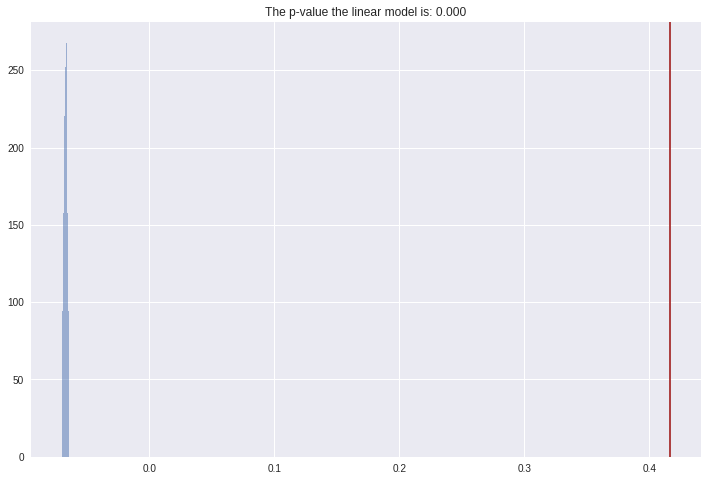

In [105]:
#Using the second test statistic (calculate the proportion of data that lies within the boundary from (mu-std) to (mu+std))
st = time.time()

replicated_test_statistic_2 = []
for i in range (100):
  replicated_data =[]
  test=[]
  for t in Date_diff:
    replicated = stats.norm(samples['c0'][i] + samples['c1'][i]+ samples['amplitude'][i]*
                            math.cos((2*math.pi*t)/(365.25+ samples['phi'][i])), samples['sigma'][i]).rvs (size=1)
    replicated_data.append(replicated)
  test = test_statistic_2 (replicated_data)
  replicated_test_statistic_2.append(test)
print ("Elapsed time %f" %(time.time() - st))

ps_2= [replicated_test_statistic_2[_] > true_value_2 for _ in range(len(replicated_test_statistic_2))]
plt.figure(figsize=(12,8))
plt.hist(replicated_test_statistic_2, alpha = 0.5, density = True)
plt.axvline(x=true_value_2, color = 'brown')
plt.title ('The p-value the linear model is: %.3f' %np.mean(ps_2))
plt.show()

In [108]:
true_value_2

0.41681730906454784

** Intepretation of the p-value** 

Similarly, the p-value equals 0.000 represents that there is 0% cases in which the test statistic of the sampling from the posterior distribution being larger than the test statistic of the sampling from the real dataset. With p-value lower than 0.05, we can argue that the model has a deficiency in calculating the mean of the dataset. 

This deficiency implies that the model fails to replicate the real data. Indeed, the value of the data cannot be negative. The negative mean of the replicated data implies that the model has failed to put constraints on the parameters. 


## **OVERVIEW OF THE QUADRATIC MODEL**

---



The **scenario** you are modeling, what **assumptions** you made and why, what your **parameters** are, what the priors over your parameters are and how you selected your **priors**.

* **Assumptions**: This model has one main assumption: the data comes from a normal distribution with the mean of the distribution is the sum of the long-term trend and seasonal variation. The long-term trend is assumed to be a ***quadratic*** model under the form $a + bt + ct^2$ while the seasonal variation is assumed to have the cosin function, expressed by the form $c_2cos(2t\pi/365.25+c_3)$. 
* **Parameters and priors**:

 * **a**: (constant term): I inform this mean by using the parameters defined by Pystan above

 * **b** (linear coefficient): I use [Desmos.com](https://https://www.desmos.com/calculator) to draw a graph. By changing different constant, I found 0.00003 to be a reasonable prior for Pystan model. 

 * **c** (quadratic coefficient): As the model is going upward, the quadratic coefficient must be bigger than 0. I use [Desmos.com](https://https://www.desmos.com/calculator) to draw a graph. By changing different constant, I found 0.000000001 to be a reasonable prior for Pystan model. 
 
 * **c2**(amplitude of the seasonal variation): Drawn from a cauchy distribution. I inform the mean of this distribution by using the parameters defined by Pystan above

 * **c3** (phi of the cosin function of the seasonal variation): Drawn from a cauchy distribution. I inform the mean of this distribution by using the parameters defined by Pystan above. I put the constraint of $c_3$ from $-\pi$  to $\pi$ value because the the region from $-\pi$  to $\pi$  has covered all the possible values of cosin. 

 * **c4** (noise of the model): Drawn from a cauchy distribution. I inform the mean of this distribution by using the parameters defined by Pystan above


## Building a new model - Quadratic long-term trend

---

This new model will using a quadratic function to resemble the long-term trend of the CO2. Instead of using the linear model, I will be using a quadratic model to find c0 and c1. The quadratic model would be in this form: $a + b*t + c^2*t$; which will reflect the long-term trend

In [0]:
# Choose a new dataset for a Stan model.
# The first 2000 variables are used as a train set, while the rest is the test set. 

stan_data_2 = {
  'CO2': CO2 [:2000],
  'Date': Date [:2000],
  'N': len(CO2 [:2000]),
  'Date_future': Date[2000:],
  'Date_future_len':len(Date[2000:])}

In [37]:
st = time.time()

stan_code_2 = """
data {
  int<lower=0> N;  // The number of observed value
  real CO2[N];       // CO2 values
  int <lower=0> Date[N]; // Date values
  int <lower=0> Date_future_len; // The number of future data
  int<lower=0> Date_future[Date_future_len]; // Future data 
}

parameters {
  real a;                         // Intercept in the long-term trend
  real b;                         // First order correlation term in the long-term trend
  real <lower=0> c;               // Second order correlation term in the long-term trend
  real <lower=0> amplitude ;       // Seasonal variation
  real <lower=-pi(),upper=pi()> phi; // Seasonal variation
  real sigma;                      // Noise
}

model {
  // Priors over 5 parameters
  a ~ normal(-0.07,0.1);  //the intercept calculated from Pystan above
  b ~ normal(0.00003,0.0002); //using Desmos to graph random values for b
  c ~ normal (0.000000001,0.0000001); //using Desmos to graph random values for c
  phi ~ cauchy (0.6,0.5); // using the phi parameter calculated from Pystan above
  amplitude ~ cauchy (0.03, 0.5); // using the amplitude parameter calculated from Pystan above
  sigma ~ cauchy (0,0.1); // noise
  
  // Likelihood
  for(i in 1:N) {
    CO2[i] ~ normal(a + b*Date[i] + c*(Date[i]^2) + amplitude*cos((2*pi()*Date[i])/(365.25+phi)), sigma);
  }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[Date_future_len];
    for(t in 1:Date_future_len) {
        x_future[t] = normal_rng(
            a + b*(Date_future[t]) + c*(Date_future[t]^2) + amplitude*cos((2*pi()*Date_future[t])/(365.25+phi)), sigma);
    }
}
"""

stan_model_2 = pystan.StanModel(model_code=stan_code_2)
print ("Elapsed time %f" %(time.time() - st))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_221ab0a7e81debf1987534abebbb4883 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpv58e5o03/stanfit4anon_model_221ab0a7e81debf1987534abebbb4883_1264232554570098248.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Elapsed time 74.899757


In [38]:
st = time.time()
parameters_2 = ['a', 'b', 'c', 'amplitude', 'phi','sigma']
results_2 = stan_model_2.sampling(data=stan_data_2)
print(results_2.stansummary(pars=parameters_2))
samples_2 = results_2.extract()
print ("Elapsed time %f" %(time.time() - st))

Inference for Stan model: anon_model_221ab0a7e81debf1987534abebbb4883.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a           0.01  1.7e-5 7.5e-4   0.01   0.01   0.01   0.01   0.01   1873    1.0
b         2.2e-5  6.1e-9 2.4e-7 2.1e-5 2.2e-5 2.2e-5 2.2e-5 2.2e-5   1486    1.0
c        9.7e-10 4.1e-131.6e-119.4e-109.6e-109.7e-109.8e-10 1.0e-9   1473    1.0
amplitude   0.03  6.2e-6 3.2e-4   0.03   0.03   0.03   0.03   0.03   2676    1.0
phi         0.92  6.3e-4   0.03   0.86    0.9   0.92   0.94   0.98   2346    1.0
sigma       0.01  2.6e-6 1.7e-4   0.01   0.01   0.01   0.01   0.01   4304    1.0

Samples were drawn using NUTS at Fri Dec 21 16:17:23 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Elapsed time 162.8074

**Interpretation about the Pystan result**

---

The result implies a good MCMC sampling from Pystan. High n_eff values imply that those parameters are independent, while Rhat implies that variations in 4 different chain are similar of the variations among 4 chains

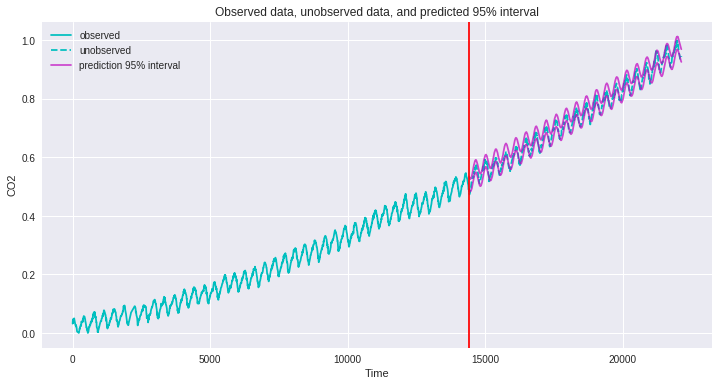

In [39]:
prediction_2 = samples_2['x_future']

# Compute 95% interval of the predicted values
prediction_interval_2 = np.percentile(prediction_2, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
x_predicted_plot = Date[2000:]
plt.plot(Date[:2000],CO2_norm[:2000], 'c-', label='observed') #Draw the observed values
plt.plot(Date[2000:],CO2_norm[2000:], 'c--', label='unobserved') #Draw the unobserved values
plt.plot(x_predicted_plot,prediction_interval_2[0],'m-', alpha = 0.7, label='prediction 95% interval') 
#Plot the lower bound of the 95% confidence interval
plt.plot(x_predicted_plot, prediction_interval_2[1],'m-', alpha = 0.7) 
#Plot the upper bound of the 95% confidence interval 
plt.axvline(Date[2000], color='red')

plt.xlabel('Time')
plt.ylabel('CO2')
plt.legend()
plt.title('Observed data, unobserved data, and predicted 95% interval')
plt.show()

**Intepretation of the result**

---

The graph above plots the observed variables represented by a normal blue line (2000 recorded items of CO2), unobserved variables represented by a dash blue line (1090 recorded items of CO2) and the confidence interval of those unobserved variables. By using a part of the data as a train set and a part as a test set, we can observe the precision of the model. The confidence interval reasonably covers all the dash line, which implies that the model (informed by train set) perfoms well with the test set. We will check the test statistic below to see more result. 

**Test statistic**

Elapsed time 81.440415


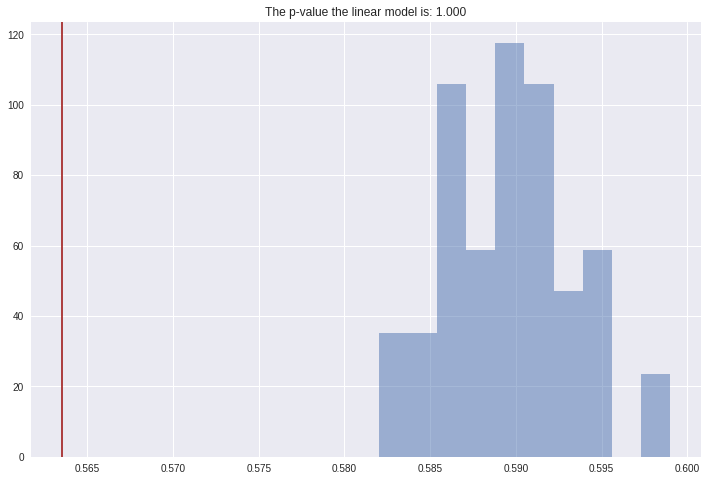

In [40]:
#Using the first test statistic; check the proportion of data from (mu-std) to (mu+std)
st = time.time()
true_value_3 = test_statistic (CO2 [:2000])
replicated_test_statistic_3 = []
for i in range (50):
  replicated_data =[]
  test=[]
  for t in Date[:2000]:
    replicated = stats.norm(samples_2['a'][i] + samples_2['b'][i]*t + samples_2['c'][i]*t*t + 
                            samples_2['amplitude'][i]*math.cos((2*math.pi*t)/(365.25+ samples_2['phi'][i])), 
                            samples_2['sigma'][i]).rvs (size=1)
    replicated_data.append(replicated)
  test = test_statistic (replicated_data)
  replicated_test_statistic_3.append(test)
  
print ("Elapsed time %f" %(time.time() - st))

ps_3= [replicated_test_statistic_3[_] > true_value_3 for _ in range(len(replicated_test_statistic_3))]
plt.figure(figsize=(12,8))
plt.hist(replicated_test_statistic_3, alpha = 0.5, density = True)
plt.axvline(x=true_value_3, color = 'brown')
plt.title ('The p-value the linear model is: %.3f' %np.mean(ps))
plt.show()

**Intepretation of the test statistic**

---

This test statistic implies that this model has a deficiency in modelling the samples. While the confidence interval above performs well with the unobserved data, this test statistic implies that the model fails to replicate the data that is similar to the true data; regarding the test statistic criteria. 

However, the deficiency of this model is significantly smaller than the original model. There is an approximate 0.03 difference (with the real data) of this quadratic model; while there is an approximate 0.1 difference in the linear model.

While still failling to replicate the data, this is an improvement from the original model. However, this implies that the upgraded model should attempt to build the parameters that can include more extreme values.

Elapsed time 161.179035


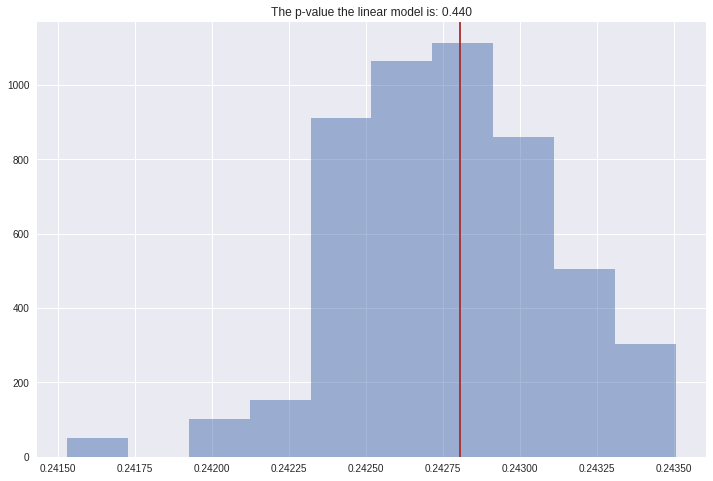

In [41]:
#Using the second test statistic; compare the mean of the replicated data with the mean of the real data
st = time.time()
true_value_4 = test_statistic_2 (CO2 [:2000])
replicated_test_statistic_4 = []
for i in range (100):
  replicated_data =[]
  test=[]
  for t in Date[:2000]:
    replicated = stats.norm(samples_2['a'][i] + samples_2['b'][i]*t + samples_2['c'][i]*t*t 
                            + samples_2['amplitude'][i]*math.cos((2*math.pi*t)/(365.25+ samples_2['phi'][i])), 
                            samples_2['sigma'][i]).rvs (size=1)
    replicated_data.append(replicated)
  test = test_statistic_2 (replicated_data)
  replicated_test_statistic_4.append(test)
  
print ("Elapsed time %f" %(time.time() - st))

ps_4= [replicated_test_statistic_4[_] > true_value_4 for _ in range(len(replicated_test_statistic_4))]
plt.figure(figsize=(12,8))
plt.hist(replicated_test_statistic_4, alpha = 0.5, density = True)
plt.axvline(x=true_value_4, color = 'brown')
plt.title ('The p-value the linear model is: %.3f' %np.mean(ps_4))
plt.show()

**Intepretation of the test statistic**

---

This test statistic with p-value stays at 0.49 nearly describes the perfect replication of the data using the parameters. This plot implies that the model is able to replicate the training set. Half of the replicated data stays above the true value, while the other half stays below the true value. However, this test statistic does not mean that this second model is significantly better than the first model. Because the training set of two models are different, we cannot make any conclusion based on this graph. The first linear model uses all the data from 1958 to 2018 as the training set; while this quadratic model uses the first 2000 items as the training set. The model, however, implies that there is a chance that this quadratic model can predict the data better than the linear model. I will use the same quadratic model but using all the data from 1958 to 2018 as the training set. Thereafter, I will check the validity of the quadratic model using test statistic.

## Predict the future using the new model with quadratic long-term trend

In [0]:
stan_data_3 = {
  'CO2': CO2,
  'Date': Date,
  'N': len(CO2),
  'Date_future': Date_future,}

In [10]:
# The Stan model and data. Running this cell compiles the Stan model, which
# takes some time.

st = time.time()

stan_code_3 = """
data {
  int<lower=0> N;  // Number of data
  real CO2[N];       // Data values about CO2 amount
  int <lower=0> Date[N]; // Data values about date
  int<lower=0> Date_future; // Future data to predict
}

parameters {
  real a;                         // Individual factor in the long-term
  real <lower=0> b;             // Correlation term in the long-term trend
  real <lower=0> c;               // Correlation term in the long-term trend
  real <lower=0> amplitude ;       // Seasonal variation
  real <lower=-pi(),upper=pi()> phi; // Seasonal variation
  real sigma;                      // Noise
}

model {
  // Priors over 5 parameters
  a ~ normal(-0.07,0.1);
  b ~ normal(0.00003,0.0002);
  c ~ normal (0.000000001,0.0000001);
  phi ~ cauchy (0.6,0.5);
  amplitude ~ cauchy (0.03, 0.5);
  sigma ~ cauchy (0,0.1);
  
  // Likelihood
  for(i in 1:N) {
    CO2[i] ~ normal(a + b*Date[i] + c*(Date[i]^2) + amplitude*cos((2*pi()*Date[i])/(365.25+phi)), sigma);
  }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[Date_future];
    for(t in 1:Date_future) {
        x_future[t] = normal_rng(
            a + b*(Date[N]+t) + c*((Date[N]+t)^2) + amplitude*cos((2*pi()*(Date[N]+t))/(365.25+phi)), sigma);
    }
}
"""

stan_model_3 = pystan.StanModel(model_code=stan_code_3)
print ("Elapsed time %f" %(time.time() - st))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_163e7199a264a66406e2037827e57489 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp2i1_zptc/stanfit4anon_model_163e7199a264a66406e2037827e57489_1056462706323897361.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Elapsed time 79.678091


In [11]:
st = time.time()
parameters_3 = ['a', 'b', 'c', 'amplitude', 'phi','sigma']

results_3= stan_model_3.sampling(data=stan_data_3)
print(results_3.stansummary(pars=parameters_3))
samples_3 = results_3.extract()
print ("Elapsed time %f" %(time.time() - st))

Inference for Stan model: anon_model_163e7199a264a66406e2037827e57489.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a           0.01  1.5e-5 6.0e-4   0.01   0.01   0.01   0.02   0.02   1597    1.0
b         2.2e-5  3.4e-9 1.2e-7 2.1e-5 2.1e-5 2.2e-5 2.2e-5 2.2e-5   1349    1.0
c        9.7e-10 1.4e-135.4e-129.6e-109.7e-109.7e-109.7e-109.8e-10   1418    1.0
amplitude   0.03  6.0e-6 2.7e-4   0.03   0.03   0.03   0.03   0.03   2066    1.0
phi         0.56  3.1e-4   0.02   0.53   0.55   0.56   0.57   0.59   2554    1.0
sigma       0.01  2.1e-6 1.4e-4   0.01   0.01   0.01   0.01   0.01   4226    1.0

Samples were drawn using NUTS at Fri Dec 21 15:16:09 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Elapsed time 676.2188

**Intepretation of the result**

---

The n_eff number is above 400, reasonably good. Rhat still stays at 1.0, which is good. This means that the samples of parameters are uncorrelated. I will plot out the autocorrelation plot and the pair plots to see the relationship more clearly. 


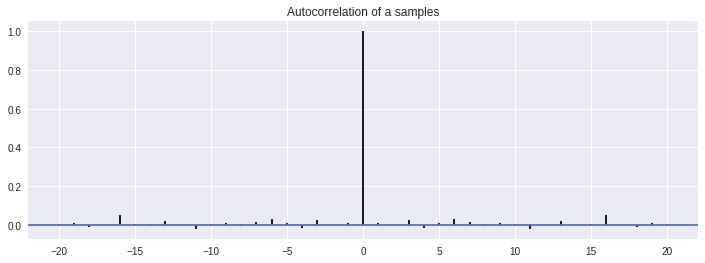

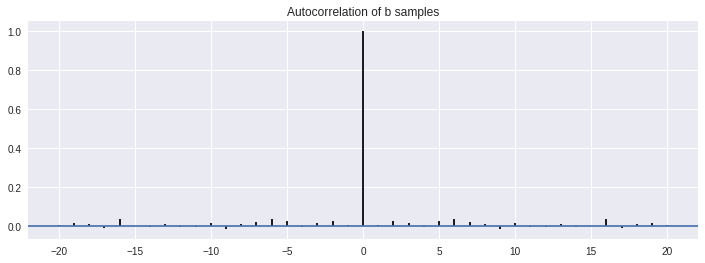

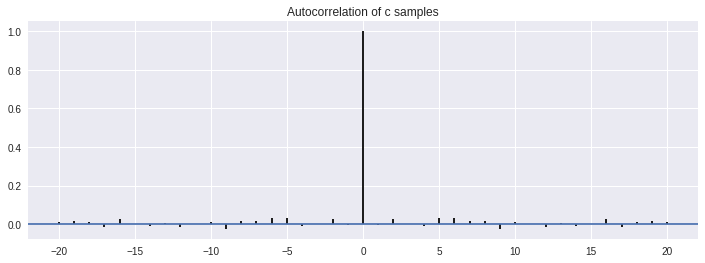

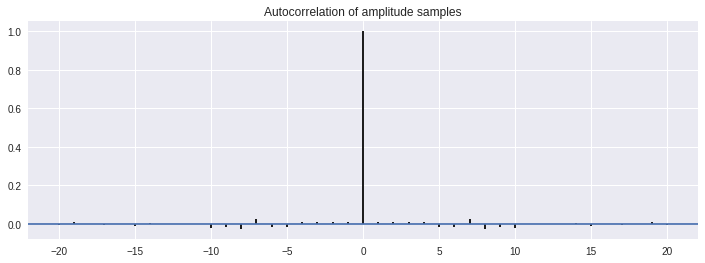

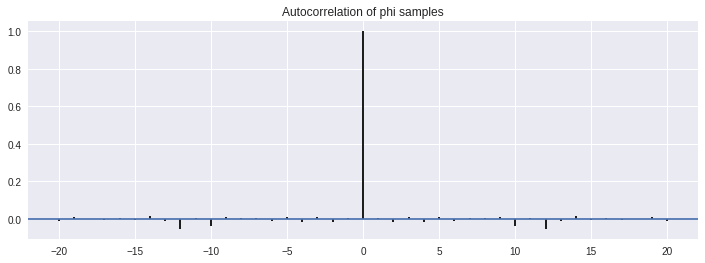

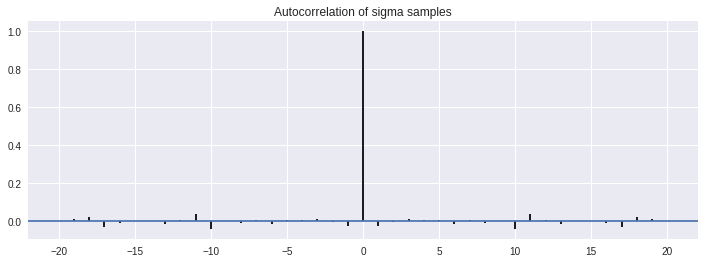

In [52]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters_3:
    plt.figure(figsize=(12, 4))
    plot_acf(samples_3[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

** Intepretation of the autocorrelation of the parameters ** 

There is a high independence of parameters in the MCMC sampling. All the autocorrelation at all lags are below 0.05. 

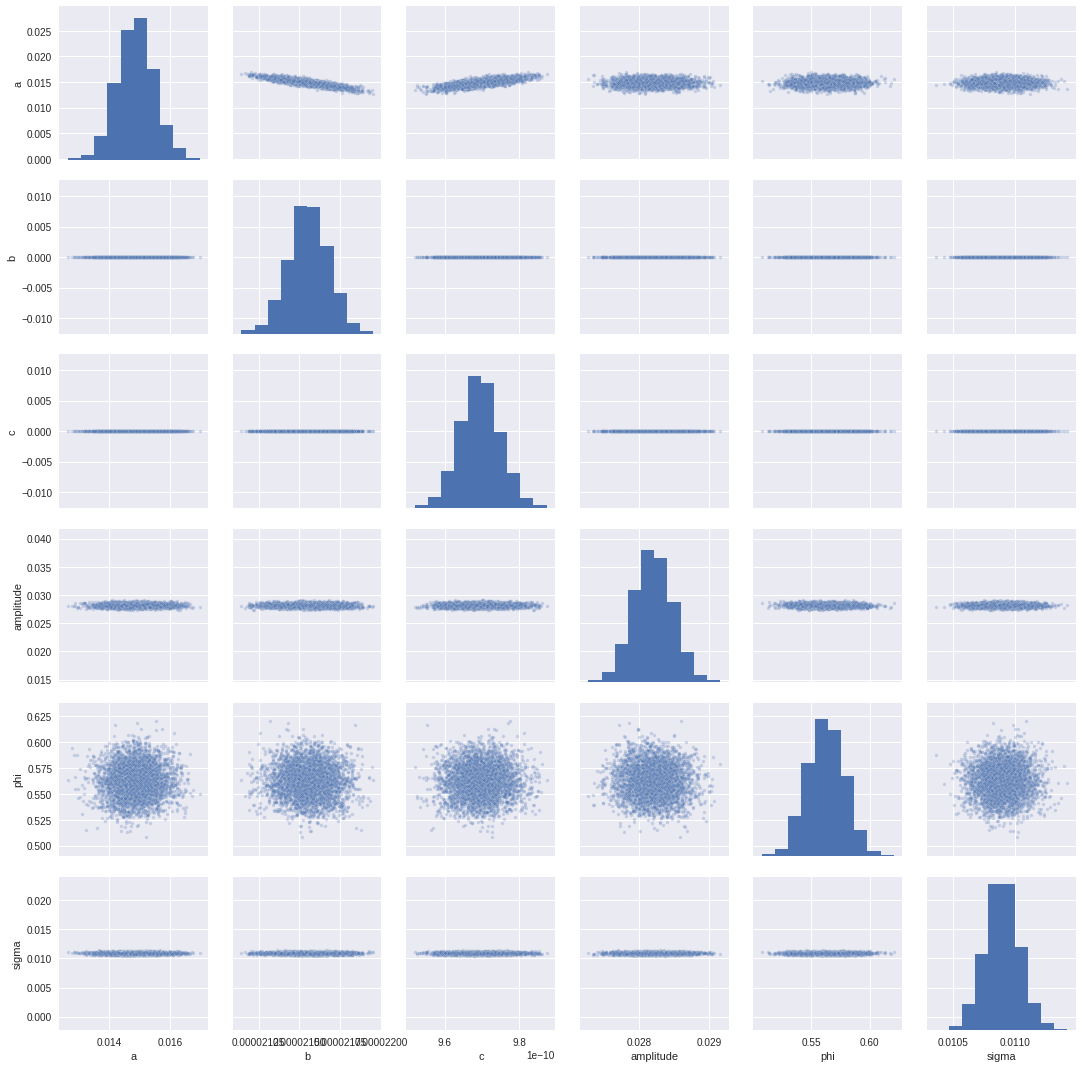

In [13]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([samples_3[param] for param in parameters_3]),
    columns=parameters_3)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

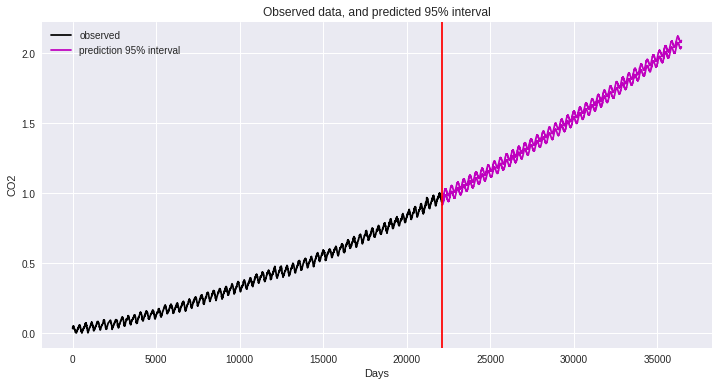

In [15]:
prediction_3 = samples_3['x_future']

# Compute 95% interval of the predicted values
prediction_interval_3 = np.percentile(prediction_3, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
x_plot = [max(Date_diff) + i + 1 for i in range (Date_future)]
plt.plot(Date_diff,CO2_norm, 'k-', label='observed')
plt.plot(x_plot,prediction_interval_3[0],'m-', label='prediction 95% interval')
plt.plot(x_plot, prediction_interval_3[1],'m-')
plt.axvline(max (Date_diff), color='red')
plt.xlabel('Days')
plt.ylabel('CO2')
plt.legend()
plt.title('Observed data, and predicted 95% interval')
plt.show()

Elapsed time 251.584758


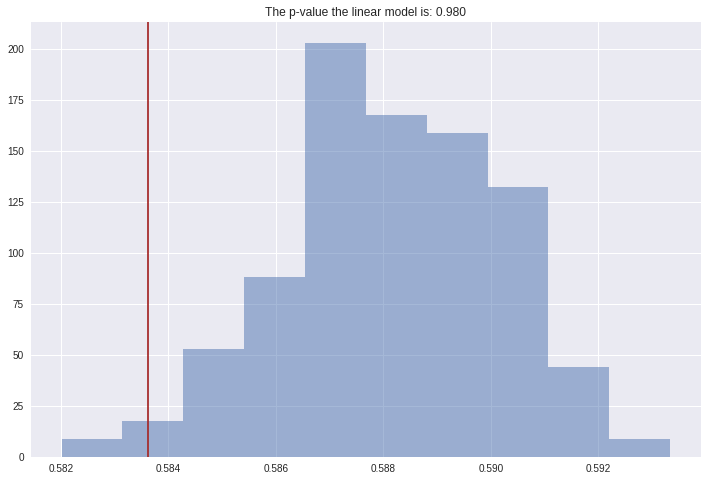

In [22]:
#Using the first test statistic (calculate the proportion of data that lies within the boundary from (mu-std) to (mu+std))
st = time.time()

true_value_5 = test_statistic (CO2)
replicated_test_statistic_5 = []
for i in range (100):
  replicated_data =[]
  test=[]
  for t in Date_diff:
    replicated = stats.norm(samples_3['a'][i] + samples_3['b'][i]*t + samples_3['c'][i]*t*t + 
                            samples_3['amplitude'][i]*math.cos((2*math.pi*t)/(365.25+ samples_3['phi'][i])), 
                            samples_3['sigma'][i]).rvs (size=1) 
    #Using the first test statistic; check the proportion of data from (mu-std) to (mu+std)
    replicated_data.append(replicated)
  test = test_statistic (replicated_data)
  replicated_test_statistic_5.append(test)
print ("Elapsed time %f" %(time.time() - st))

ps_5= [replicated_test_statistic_5[_] > true_value_5 for _ in range(len(replicated_test_statistic_5))]
plt.figure(figsize=(12,8))
plt.hist(replicated_test_statistic_5, alpha = 0.5, density = True)
plt.axvline(x=true_value_5, color = 'brown')
plt.title ('The p-value the linear model is: %.3f' %np.mean(ps_5))
plt.show()

** Intepretation of the model ** 

This quadratic model is a huge improvement from the linear model, regarding the criteria of this test statistic. As the rule of thumb is that p-value should not be larger than 0.95, this result implies that the quadratic model is still suspicious. However, comparing to the linear model when there is a 0.1 difference between the true data and the replicated data, this model covers a broader range of the extreme values, unlike the linear model. 

However, this model does not satisfy the standard test statitstic either and still needs to refine. One possible solution is to change the amplitude of the seasonal variations. 

Elapsed time 259.805588


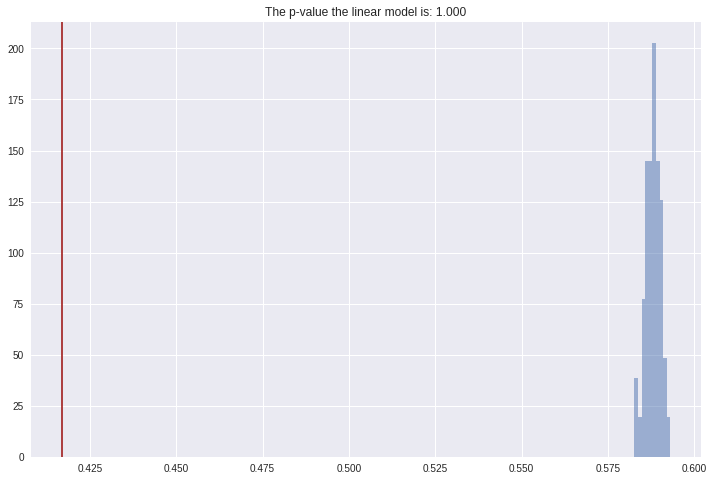

In [110]:
#Using the second test statistic (calculate the mean of the data)
st = time.time()

true_value_6 = test_statistic_2 (CO2)
replicated_test_statistic_6 = []
for i in range (100):
  replicated_data =[]
  test=[]
  for t in Date_diff:
    replicated = stats.norm(samples_3['a'][i] + samples_3['b'][i]*t + samples_3['c'][i]*t*t + 
                            samples_3['amplitude'][i]*math.cos((2*math.pi*t)/(365.25+ samples_3['phi'][i])), 
                            samples_3['sigma'][i]).rvs (size=1) 
    #Using the first test statistic; check the proportion of data from (mu-std) to (mu+std)
    replicated_data.append(replicated)
  test = test_statistic (replicated_data)
  replicated_test_statistic_6.append(test)
print ("Elapsed time %f" %(time.time() - st))

ps_6= [replicated_test_statistic_6[_] > true_value_6 for _ in range(len(replicated_test_statistic_6))]
plt.figure(figsize=(12,8))
plt.hist(replicated_test_statistic_6, alpha = 0.5, density = True)
plt.axvline(x=true_value_6, color = 'brown')
plt.title ('The p-value the linear model is: %.3f' %np.mean(ps_6))
plt.show()

** Intepretation of the test statistic result ** 

This test statistic shows that the model fails to replicate the data. In this model, the mean of the replicated data is larger than the mean of the true data. In the original linear model, the replicated data has the negative mean, which is impossible when looking into the regression line plot. This graph does not inform which model works better; because both have failed the test statistic. 

## When do we have the dangerous level of CO2?

The quadratic model seems to perform better with the first test statistic. I chose the quadratic model to predict the level of CO2

In [111]:
#Calculate the value of dangerous CO2 using the normalization
CO2_origin = data["CO2"]
CO2_danger = (450 - min(CO2_origin)) / (max (CO2_origin)-min(CO2_origin))
CO2_danger

1.3866558671661435

 We can conclude that there is a strong probability for the CO2 to reach the threshold by looking at the lower bound. If the lower bound of the quadratic model reaches 1.3866, there is a dangerous level of CO2. 

In [112]:
a = 0
for i in prediction_interval_3[1]: 
  if i < CO2_danger: 
    a +=1 
  if i == CO2_danger or i  >= CO2_danger:
    break

print ("There is a strong probability of CO2 reaching the alarming state at %i days after the end of recording of CO2 in 2018, which is:" %(a))
print (data["Time"][len(CO2)-1] + datetime.timedelta (a))


There is a strong probability of CO2 reaching the alarming state at 5319 days after the end of recording of CO2 in 2018, which is:
2033-05-20 00:00:00


** Explain the result to non-Bayesian people **

We use Bayesian to predict when the CO2 amount reaches the dangerous threshold at 450 ppm. The CO2 amount recorded in October 2018 is around 406 ppm. We use time-series technique, which is, predicting the future by looking at the properties of the CO2 value in the past. 

There is a pattern of CO2 increase from 1958 to 2018. We have the recorded data from the history. I built up my own hypothesis about how the CO2 amount increases over time. After that, I check the validity of my hypothesis (model) by replicate the old data using my model. The validity checking is conducted with Bayesian technique. The main concept behind Bayesian technique is to calculate the probability that my model would explain the data. A better model can explain the historical data better than other models.

I used the model that can best replicate the historical data to predict the future. 

Please note that the main assumption behind the time series technique is that there should be no significant changes that can influence the variables. For example, if the Paris climate change agreement collapses after the U.S. withdrawal, the time series will fail to predict the future. The CO2 amount has been constrained by the Kyoto Protocol in 1997, and now Paris agreement. Because of the continous agreement in climate change, the time series prediction has a foundation to be valid. 

Using this model, the CO2 would reach the alarming threshold in 2033, which is 15 years from now. 

### Two factor graphs representing the linear model and the quadratic model respectively